In [294]:
from sklearn.decomposition import PCA
from sklearn.utils import safe_mask

import xarray as xr
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')

In [68]:
# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-40, 40.),
        'lat' : (65, 85),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 15.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

In [595]:
## Function to crop the dataset
def Crops(coord, d_set, dictionary):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by a dictionary.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
            
        dictionary: dic
            name of the dictionary wwith the coordinates
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """

    lon1, lon2 = dictionary[coord]['lon']
    lat1, lat2 = dictionary[coord]['lat']
    name_fig = dictionary[coord]['name']

    return(d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2)))



def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)
    
    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)


def Limits(data_set):
    
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    return(mn, mx)


def Normalize(data_set):
    mn = data_set.min(dim='week', skipna=True)
    mx = data_set.max(dim='week', skipna=True)
    
    y = (data_set - mn) / (mx - mn)
    return y


def Re_arrange(data_set, years):
    g = []

    for i,y in enumerate(years):
        aa = points.sel(time=points.time.dt.year==y)
        aa = aa.groupby('time.week').mean(dim='time', skipna=True)

        aa = aa.sel(week=slice(1,52))
        g.append(aa)
        del aa

    return(g)



def Shift(data_set):
    max_w = data_set.groupby('point').argmax(dim='week', keep_attrs=True, skipna=True).values
    r = 26 - max_w 
    
    data = data_set.T.values
    del data_set
    
    rows, column_indices = np.ogrid[:data.shape[0], :data.shape[1]]
    r[r < 0] += data.shape[1]
    column_indices = column_indices - r[:, np.newaxis]
    shft = data[rows, column_indices]
    shift = xr.DataArray(shft.T, dims=['week', 'point'], name='mlotst')

    return(shift)

In [578]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################
dir_1 = '../../New_ARMOR/'
dir_15 = '/net/data0-gw/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_of = '/home/lgarcia/Documents/Other_datasets/'
dir_oi = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'

c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)

In [579]:
d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

## Doing a version for a small area: Gulf Stream

Using al the grid points.

In [580]:
coord = 'gul'
region = Crops(coord, c_armor1, reg_ext)
region2 = Crops(coord, c_armor15, reg_ext)

region2 = Masking(region2, region2.to[0,25])

In [581]:
points = region.mlotst[:,::4,::4].where(region2.mask==1)

print(points.latitude.size, points.longitude.size)

15 30


In [582]:
#del c_armor1, c_armor15, region2, region, weeks, d1, d2

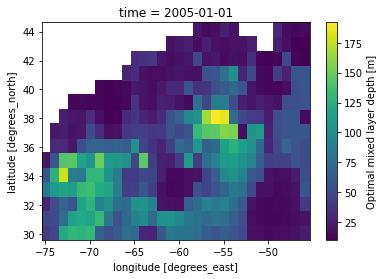

In [583]:
points[0].plot()

In [584]:
#yr = points.time.dt.year
#points.coords['year'] = (('time'), yr)

In [585]:
#del la, lo, valsla, valslo

## Re-shaping the dataset: using http://nicolasfauchereau.github.io/climatecode/posts/eof-analysis-with-scikit-learn/

The analysis ignores the 2018 because is not complete. The shift is done to put the maximum at the meiddle of the year (at week 26).

In [596]:
years = [y for y in range(2005, 2018)]

nn = Re_arrange(points, years)
new_points = xr.concat(nn, dim='year')

In [597]:
new_points.shape

(13, 52, 15, 30)

In [598]:
new_points

,Array,Chunk
Bytes,2.43 MB,3.60 kB
Shape,"(13, 52, 15, 30)","(1, 1, 15, 30)"
Count,4742 Tasks,676 Chunks
Type,float64,numpy.ndarray


In [652]:
new_points[0,,0,0].values

array(17.)

### re-shape to 2D

In [742]:
lat = new_points['latitude'].values
lon = new_points['longitude'].values
mld = new_points.values

In [743]:
lons, lats = np.meshgrid(lon, lat)

In [744]:
mld.shape

(13, 52, 15, 30)

In [745]:
mld[0].shape

(52, 15, 30)

In [746]:
mld = np.moveaxis(mld, 0, 1)

In [748]:
mld.shape

(52, 13, 15, 30)

In [750]:
X = np.reshape(mld, (mld.shape[0], mld.shape[1]*len(lat) * len(lon)), order='F')

In [751]:
X.shape

(52, 5850)

### masking the land grid points

In [752]:
from numpy import ma

In [753]:
type(X)

numpy.ndarray

In [754]:
X = np.ma.masked_array(X, np.isnan(X))

In [755]:
type(X)

numpy.ma.core.MaskedArray

In [756]:
land = X.sum(0).mask

In [757]:
ocean = ~land

### keeping just (deep) ocean values

In [758]:
X = X[:,ocean]

In [759]:
X

masked_array(
  data=[[37.0, 18.0, 99.0, ..., 13.0, 13.0, 16.0],
        [46.0, 61.0, 96.0, ..., 12.0, 13.0, 17.0],
        [88.0, 27.0, 103.0, ..., 12.0, 13.0, 14.0],
        ...,
        [27.0, 31.0, 80.0, ..., 36.0, 16.0, 27.0],
        [24.0, 30.0, 62.0, ..., 22.0, 16.0, 16.0],
        [70.0, 76.0, 77.0, ..., 19.0, 14.0, 15.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20)

In [760]:
print(X.mean())
print(X.std())

39.29065702230259
41.80229699991215


In [761]:
np.any(np.isnan(X))

False

In [762]:
np.all(np.isfinite(X))

True

In [763]:
X = X.astype(np.float)

In [764]:
from sklearn.impute import SimpleImputer


imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)

X3 = imp.transform(X)

In [794]:
X3.shape

(52, 4953)

# PCA for the original dataset

## Seasonal cycle for some points in the region

In [765]:
#new_points[:,100:138:5].T.plot(col="point", col_wrap=3, hue='point')

In [766]:
# Run the PCA analysis:
n_components = 12  # Rq: n_components cannot exceed ncols !
pca = PCA(n_components=n_components)

In [850]:
# eigenvectors
pca = pca.fit(X3.T)

In [851]:
# Loadings
pca.components_.shape

(12, 52)

In [852]:
print(pca.components_.size, pca.components_.shape)

624 (12, 52)


In [853]:
print(pca.singular_values_, pca.singular_values_.shape)

[12175.44866037  5102.74181734  4171.12796206  3652.13072613
  3441.95322151  3020.39378025  2902.28599702  2708.58933788
  2666.25637687  2463.21288832  2413.06668652  2325.29534686] (12,)


In [854]:
# Principal components :: make the projection 
reduced_values = pca.transform(X3.T)
reduced_values.shape

(4953, 12)

In [841]:
# the shape is : (4550, 12)
reduced_values[0]

array([2318.92134947, -746.1741158 , -648.4876295 , -649.84653301,
        405.73113303, -114.09199277, -106.49253699,  130.35305485,
        123.20714019,  313.55580488, -159.26673421, -389.63997999])

In [842]:
EOFs = pca.components_

In [843]:
EOFs = EOFs[:12,:]

In [844]:
EOFs.shape

(12, 4953)

In [858]:
mld.shape[1]*len(lat) * len(lon)

5850

In [845]:
#mld.shape[0], mld.shape[1]*len(lat) * len(lon))

In [859]:
EOF_recons = np.ones((12, mld.shape[1] * len(lat) * len(lon))) * -999.

In [860]:
for i in range(12): 
    EOF_recons[i,ocean] = EOFs[i,:]

In [861]:
EOF_recons = ma.masked_values(np.reshape(EOF_recons, (12, 13, len(lat), len(lon)), order='F'), -999.)

In [862]:
EOF_recons.shape


(12, 13, 15, 30)

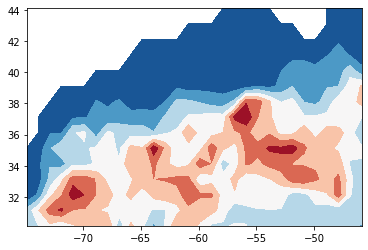

In [879]:
plt.contourf(lons, lats, EOF_recons[0,0],cmap=plt.get_cmap('RdBu_r'))

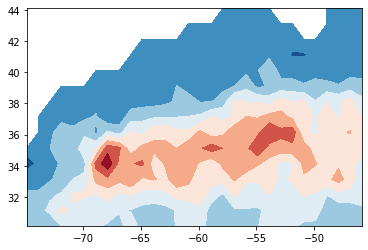

In [891]:
plt.contourf(lons, lats, EOF_recons[0,12,:,:],cmap=plt.get_cmap('RdBu_r'))

## Preparing a new data array with the results

In [788]:
samp = reduced_values.shape[0]
eof = reduced_values.shape[1]
w = new_points.week.size

data = np.zeros((samp,eof,w))

result = xr.DataArray(data, dims=['point', 'prin_comp', 'week'], name="fake_data")

In [789]:
result['reduced_data'] = xr.DataArray(reduced_values, dims=['point', 'prin_comp'])

result['loadings'] = xr.DataArray(pca.components_, dims=['prin_comp', 'week'], 
                                  attrs={'comment': 'Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.'})
result['explained_variance'] = xr.DataArray(pca.explained_variance_ratio_*100, 
                                        dims=['prin_comp'], attrs={'comment': 'Percentage of variance explained by each of the selected components'})

ValueError: conflicting sizes for dimension 'week': length 52 on <this-array> and length 4953 on 'loadings'

## Plotting the loadings

In [791]:
exp_var =  pca.explained_variance_ratio_*100

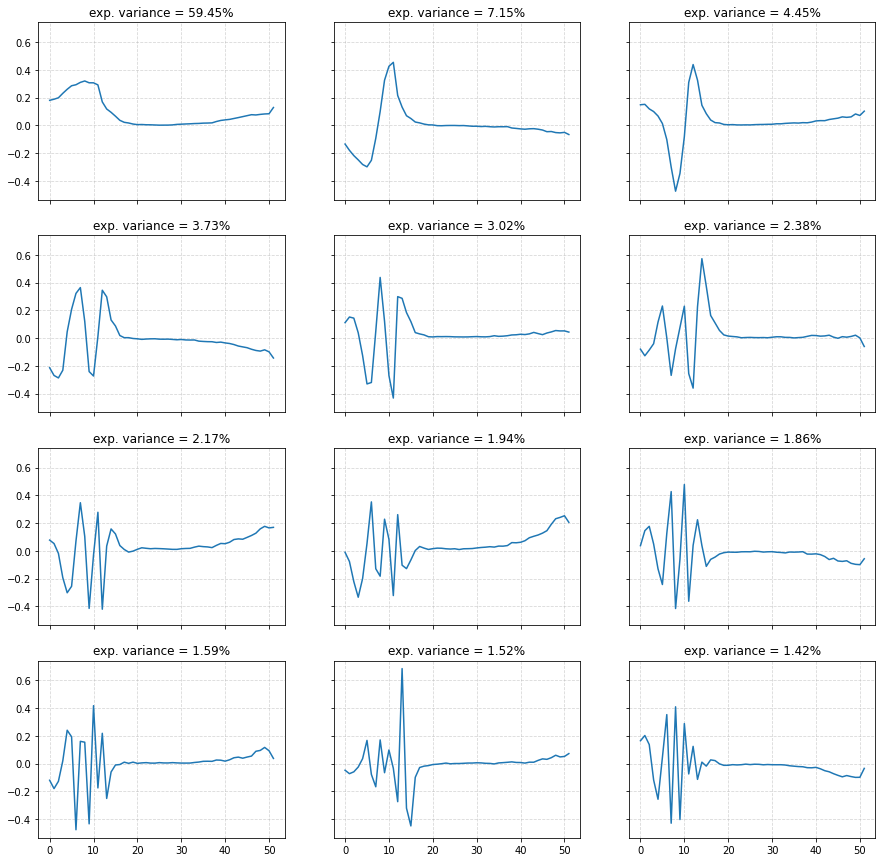

In [811]:
n_cols = 3
n_rows = 4

coeff = 0

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,15), sharex=True, sharey=True)

for i in range(n_rows):
    for j in range(n_cols):
        y = EOFs[coeff] #result['loadings'][coeff]

        ev = str('{:.2f}'.format(exp_var[coeff]))  
        name = 'exp. variance = ' + ev + '%'
        
        ax[i,j].plot(y) 
        ax[i,j].set_title(name)    
        ax[i,j].grid(linestyle='--', alpha=0.5)
        coeff += 1

plt.show()

## Explained variance of the eigenvalues

In [ ]:
result['explained_variance'].plot(label='exp.var. alone')
result['explained_variance'].cumsum(dim='prin_comp').plot(label='exp.var. sum')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

## Plot of the data projected over the PC space

In [ ]:
ncols = 4
nrows = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10), sharex=True, sharey=True, constrained_layout=True)

for i in range(nrows):
    for j in range(ncols):
        x = result['reduced_data'][:,j]#PC[j]
        y = result['reduced_data'][:,i]#PC[i]
        
        pc_x = 'PC' + str(j+1)
        pc_y = 'PC' + str(i+1)

        ax[i,j].scatter(x, y)

        ax[i,j].set_xlabel(pc_x)
        ax[i,j].set_ylabel(pc_y)
        ax[i,j].grid(linestyle='--', alpha=0.5)
        

plt.xlim(-600., 800)
plt.ylim(-600., 800)

plt.show()

In [ ]:
result

In [ ]:
result.reduced_data

In [ ]:
result.reduced_data[0:450,0].plot()